In [722]:
import numpy as np
import pandas as pd
import pandas.io.data as web
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [750]:
start_dt = datetime.datetime(2006, 4, 26)

In [962]:
GLD = web.DataReader("VNQ", 'yahoo', start_dt)

In [963]:
GLD.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2006-04-26,65.419998,65.419998,64.820000,64.959999,61400,42.709552
2006-04-27,66.000000,66.000000,64.459999,65.370003,57900,42.979119
2006-04-28,65.620003,66.070000,65.400002,65.610001,63100,43.136911
2006-05-01,65.989998,66.080002,64.620003,64.820000,48800,42.617506
2006-05-02,65.000000,65.000000,63.799999,64.160004,51800,42.183575


In [964]:
import util

def average_true_range(XYZ, lookback=21):
    XYZ_shift = XYZ.shift()
    true_range = pd.DataFrame([
        XYZ['High'] - XYZ['Low'],
        abs(XYZ['High'] - XYZ_shift['Close']),
        abs(XYZ['Low'] - XYZ_shift['Close'])
    ]).max()
    return pd.rolling_mean(true_range, lookback)

def consecutive_up_down(series):
    up = util.series(series)
    down = util.series(series)
    diff = series - series.shift()
    
    up[0] = 0
    down[0] = 0

    for i in range(1, len(series)):
        if diff[i] >= 0:
            up[i] = up[i - 1] + 1
            down[i] = 0
        else:
            down[i] = down[i - 1] + 1
            up[i] = 0
    
    return pd.DataFrame({'up_streak': up, 'down_streak': down})

In [965]:
# Turning return series into labels corresponding to direction and size,
# by translating actual percent change into a rolling z-score to standardize it,
# and then using the standardized scale to mark the return

look_forward = 15
returns = util.n_period_return(GLD['Adj Close'], look_forward)

def label_z_score(score):
    #if score < -2:
    #    return 'bigger_down'
    #if score < -1:
    #    return 'big_down'
    if score < 0:
        return 'down'
    #elif score > 2:
    #    return 'bigger_up'
    #elif score > 1:
    #    return 'big_up'
    elif score > 0:
        return 'up'
    

# Free param: z score lookback: 20
z = rolling_z_score(returns, 20)
labels = z.apply(label_z_score)
labels.groupby(labels).agg('count')

down    1178
up      1207
dtype: int64

In [966]:
returns.std()

0.066742786184624259

In [967]:
returns.mean()

0.0061054553089737356

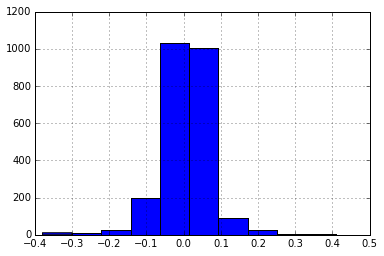

In [968]:
returns.hist()

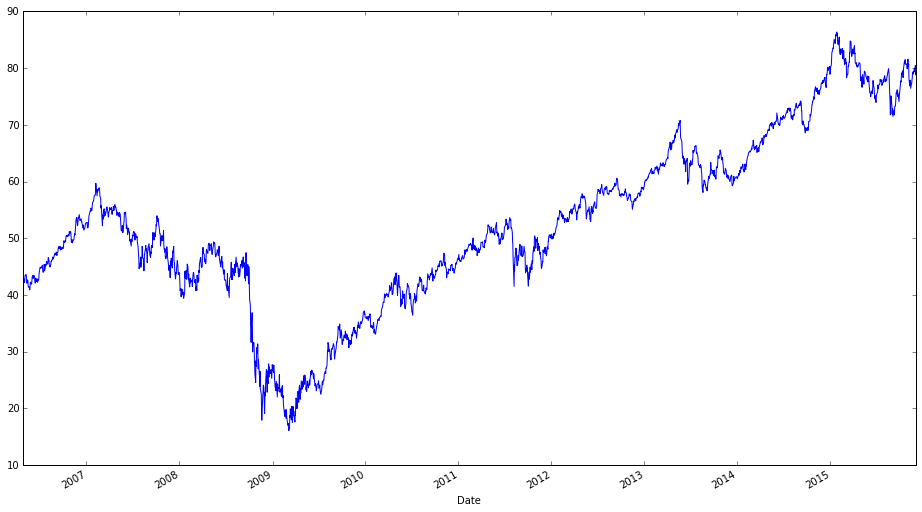

In [969]:
GLD['Adj Close'].plot(figsize=(16,9))

In [970]:
gld_close = GLD['Adj Close']

df = pd.DataFrame({
    'up_streak': up_down['up_streak'],
    'down_streak': up_down['down_streak'],
    'atr_5': average_true_range(GLD, 5),
    #'atr_20': average_true_range(GLD, 20),
    #'atr_50': average_true_range(GLD, 50),
    'over_ma_5': gld_close > util.ma(gld_close, 5),
    'over_ma_10': gld_close > util.ma(gld_close, 10),
    'over_ma_20': gld_close > util.ma(gld_close, 20),
    'over_ma_50': gld_close > util.ma(gld_close, 20),
    'over_ma_100': gld_close > util.ma(gld_close, 20),
    'ma50_over_ma_200': util.ma(gld_close, 50) > util.ma(gld_close, 200),
    'hist_ret_5': util.n_period_return(gld_close, 5),
    'hist_ret_10': util.n_period_return(gld_close, 10),
    'hist_ret_15': util.n_period_return(gld_close, 15)
})

In [982]:
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier

target = labels.shift(-look_forward).fillna('down') #TODO: Something better
clf = DecisionTreeClassifier(max_depth=8)
np.average(cross_val_score(clf, features, target, cv=30))

0.48241330422563489

In [983]:
clf.fit(features, target)
pd.crosstab(target, clf.predict(features))

col_0,down,up
row_0,,
down,892,320
up,390,817


In [984]:
zip(df.columns, clf.feature_importances_)

[('atr_5', 0.22063646169517842),
 ('down_streak', 0.0081452336209034831),
 ('hist_ret_10', 0.1780938166958117),
 ('hist_ret_15', 0.29331591291788062),
 ('hist_ret_5', 0.16391023207945946),
 ('ma50_over_ma_200', 0.059390425178710814),
 ('over_ma_10', 0.017734702771312928),
 ('over_ma_100', 0.0),
 ('over_ma_20', 0.0),
 ('over_ma_5', 0.01016531058231959),
 ('over_ma_50', 0.0030544626078388066),
 ('up_streak', 0.045553441850584318)]

In [985]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=4)
np.average(cross_val_score(clf, features, target, cv=30))

0.47967968985245413

In [989]:
from sklearn import cross_validation

def random_train_test_crosstab(clf, test_size=0.6, random_state=None):
    train_features, test_features, train_target, test_target = \
        cross_validation.train_test_split(
            features, 
            target, 
            test_size=test_size,
            random_state=random_state)

    clf.fit(train_features, train_target)
    return pd.crosstab(test_target, clf.predict(test_features))

random_train_test_crosstab(clf)

col_0,down,up
row_0,,
down,433,286
up,383,350


In [990]:
import sklearn.naive_bayes as bayes
np.average(
    cross_val_score(
        bayes.GaussianNB(), 
        np.array(df.fillna(0)), 
        labels.shift(-look_forward).fillna('down'), 
        cv=30))

0.71026360032118852

In [998]:
clf = bayes.GaussianNB()
clf.fit(np.array(df.fillna(0)), labels.shift(-look_forward).fillna('down'))
random_train_test_crosstab(clf)

col_0,down,up
row_0,,
down,423,310
up,337,382
